# Laboratorio 3
#### Integrantes:
- Juan Francisco Calderón
- Patricio Céspedes
- Adolfo Fuentes
- Catalina Quijada

## Factorización de matrices

En primer lugar, se cargan las librerías necesarias

In [1]:
from __future__ import print_function, division
from builtins import range, input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import datetime, os
import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, dot,add, Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2 as l2_reg
import itertools
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import math

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6896213421471667398
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6271533056
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7996763717728756541
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:17:00.0, compute capability: 7.5"
]


**Cargaremos el Tablero de Tensorboard**

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Carga de Datasets

**La BBDD de clicks muestra en que Ads se hizo click**

In [4]:
clicks = pd.read_csv('clicks_train.csv')

In [5]:
clicks

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0
...,...,...,...
87141726,16874592,186600,0
87141727,16874593,151498,1
87141728,16874593,282350,0
87141729,16874593,521828,0


La BBDD contiene más de 87 millones de clicks con 16.874.593 dispositivos unicos. Para realizar una prueba de concepto tomaremos una muestra de 100.000 dispositivos unicos

**BBDD de eventos tiene información del dispositivo**

In [12]:
events = pd.read_csv('events.csv')

C:\Users\afuentesj\AppData\Local\Temp\ipykernel_17544\1763814053.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv('events.csv')


In [13]:
events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


**BBDD promoted contiene información de los ad**

In [14]:
promoted = pd.read_csv('promoted_content.csv')

In [15]:
promoted.head()

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


**Realizamos un merge de la BBDD transaccional de clicks y agregamos la información de contexto del dispositivo**

In [16]:
clicks2 = pd.merge(clicks,events,on=['display_id'],how='left')

In [17]:
clicks2

,display_id,ad_id,clicked,uuid,document_id,timestamp,platform,geo_location
0,1,42337,0,cb8c55702adb93,379743,61,3,US>SC>519
1,1,139684,0,cb8c55702adb93,379743,61,3,US>SC>519
2,1,144739,1,cb8c55702adb93,379743,61,3,US>SC>519
3,1,156824,0,cb8c55702adb93,379743,61,3,US>SC>519
4,1,279295,0,cb8c55702adb93,379743,61,3,US>SC>519
...,...,...,...,...,...,...,...,...
87141726,16874592,186600,0,45f3b28fd8f19d,2823420,1123199635,2,GB
87141727,16874593,151498,1,21f03d8a66e702,2777166,1123199936,2,US>NJ>501
87141728,16874593,282350,0,21f03d8a66e702,2777166,1123199936,2,US>NJ>501
87141729,16874593,521828,0,21f03d8a66e702,2777166,1123199936,2,US>NJ>501


**Filtraremos 1000 usuarios con 800 ads, esta proporción es arbitraria**

In [18]:
n = 1000
m = 800

from collections import Counter

In [19]:
ucount = Counter(clicks2['uuid'])
adcount = Counter(clicks2['ad_id'])

uid = [u for u, c in ucount.most_common(n)]
aid = [u for u, c in adcount.most_common(m)]

**Lista de 1000 usuarios con más clicks**

In [20]:
uid 

['b88553e3a2aa29',
 'b1a50275723112',
 'c0dd2b18704e4c',
 'ff898a3605bc74',
 'dacab6a17f1867',
 '601353e79ef2dd',
 'b1952dfd930dcd',
 '10bac7f446fd09',
 'e85b02268cba31',
 '43aa03cc2c6cbd',
 '1a1b9bd5446235',
 '8c7d01f58fa4d2',
 '6c514df0b7aa98',
 'bc9287d6969974',
 '41e67875df46a1',
 'd75b62c7bfb505',
 'd8593386d8e9c5',
 '6c3ba890f6c0ed',
 '45954c7e151e6a',
 '6525c98cdc179d',
 'ab0e0f95685a25',
 '7a54a9967a0d52',
 '16bda4a85f9c98',
 '27bc2fafed4d29',
 'af464d176ac5b0',
 'f1fda88ebcc7c6',
 '2a2b131be126f3',
 'ea7da0bc513bbd',
 '1f297946d378ca',
 '151c8051de6ac6',
 'ba0ad5e1a9c5b6',
 'c40c54efe0efc3',
 '447b50ad785d60',
 'a752f1c8d2c32e',
 '37449e6fb9c271',
 '99872d7a833ac9',
 '4400972a782daf',
 'be2bca8ccdadea',
 'f5c1aeb82c994c',
 'ee9de98a7fa04b',
 'c54b861526bf29',
 '52ddb3b706fa44',
 '64415d340b42e5',
 'f1fdde950c28bb',
 '59913966809c03',
 '176b67a21ab891',
 '933a9fc1700910',
 'ea59a15df48829',
 '77d58b62ca3a41',
 '44e79c836e54bf',
 '5b90acdc502542',
 '592169a530597c',
 'a66987b395

**Lista de 800 ads con más clicks**

In [21]:
aid

[173005,
 180923,
 123742,
 151028,
 173006,
 347688,
 138353,
 130952,
 288396,
 173403,
 225438,
 174547,
 288385,
 228959,
 202812,
 92759,
 190216,
 173130,
 190062,
 61159,
 95103,
 269777,
 57071,
 187797,
 26711,
 25876,
 116261,
 141024,
 55518,
 270253,
 211592,
 153658,
 6915,
 238212,
 48185,
 173388,
 190567,
 184220,
 3314,
 303990,
 84937,
 137758,
 129491,
 470780,
 173400,
 85397,
 50861,
 262434,
 150083,
 285834,
 330515,
 46160,
 153193,
 8744,
 175214,
 198151,
 150656,
 142690,
 59628,
 93324,
 123730,
 470788,
 167294,
 162754,
 84109,
 64255,
 173384,
 141437,
 427688,
 139059,
 101761,
 147700,
 133677,
 288365,
 91945,
 39675,
 235104,
 288356,
 123732,
 225649,
 156824,
 146552,
 144739,
 78937,
 151379,
 187980,
 199220,
 23595,
 288388,
 138725,
 127712,
 68740,
 190579,
 193952,
 158632,
 38762,
 54979,
 89726,
 250319,
 231378,
 52856,
 86683,
 198129,
 123743,
 106789,
 133050,
 29046,
 201649,
 233149,
 198119,
 207178,
 31367,
 220556,
 183507,
 83666,


In [22]:
clicks3 = clicks2[clicks2['uuid'].isin(uid) & clicks2['ad_id'].isin(aid)]
clicks3

,display_id,ad_id,clicked,uuid,document_id,timestamp,platform,geo_location
4356,872,195273,0,32fdb888c57f40,1790313,62244,3,US>CA>862
6232,1226,145293,0,2a6dc933aec3d4,1791895,85672,2,US>NY>501
13037,2550,276173,0,ad51650f71ef5f,1783499,178920,1,US>CA>862
13038,2550,285834,1,ad51650f71ef5f,1783499,178920,1,US>CA>862
59175,11571,235104,0,ad51650f71ef5f,1776177,803780,1,US>CA>862
...,...,...,...,...,...,...,...,...
87092955,16865089,152335,0,d293a420fdd63c,2754912,1122564724,1,US>WI>613
87096843,16865836,194669,0,4f36be07ab8b37,2736858,1122613488,3,US>CO>751
87122920,16870929,40572,0,a1addd0c083540,1115750,1122948587,3,US>ID>757
87122923,16870929,175890,0,a1addd0c083540,1115750,1122948587,3,US>ID>757


**Se enumeran los datos cambiando el id del identificador del Ads y de uuid (Identificador unico universal) para que la programación sea más eficiente**

In [23]:
N = clicks3['uuid'].max()
M = clicks3['ad_id'].max()

user = clicks3['uuid'].value_counts().index
map = {k:i for i, k in enumerate(user)}
clicks3['uuid'] = clicks3['uuid'].map(map)
ad = clicks3['ad_id'].value_counts().index
map = {k:i for i, k in enumerate(ad)}
clicks3['ad_id'] = clicks3['ad_id'].map(map)

C:\Users\afuentesj\AppData\Local\Temp\ipykernel_17544\2987960852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks3['uuid'] = clicks3['uuid'].map(map)
C:\Users\afuentesj\AppData\Local\Temp\ipykernel_17544\2987960852.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks3['ad_id'] = clicks3['ad_id'].map(map)


In [24]:
clicks3

,display_id,ad_id,clicked,uuid,document_id,timestamp,platform,geo_location
4356,872,201,0,537,1790313,62244,3,US>CA>862
6232,1226,51,0,794,1791895,85672,2,US>NY>501
13037,2550,266,0,242,1783499,178920,1,US>CA>862
13038,2550,243,1,242,1783499,178920,1,US>CA>862
59175,11571,134,0,242,1776177,803780,1,US>CA>862
...,...,...,...,...,...,...,...,...
87092955,16865089,165,0,160,2754912,1122564724,1,US>WI>613
87096843,16865836,648,0,260,2736858,1122613488,3,US>CO>751
87122920,16870929,419,0,644,1115750,1122948587,3,US>ID>757
87122923,16870929,554,0,644,1115750,1122948587,3,US>ID>757


### Estadistica Descriptiva de Usuarios - ADS

<AxesSubplot:xlabel='ad_id', ylabel='count'>

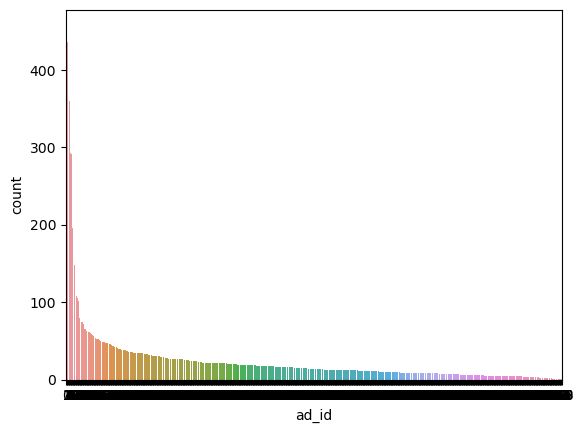

In [25]:
sns.countplot(x=clicks3['ad_id'])

**Se observa que algunso ads aparecieron mas de 450 veces, pero la gran mayoria solo apareció menos de 100 veces**

<AxesSubplot:xlabel='uuid', ylabel='count'>

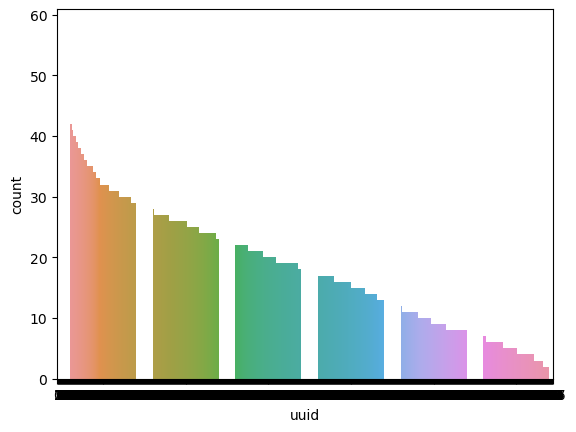

In [26]:
sns.countplot(x=clicks3['uuid'])

**Se observa que Algunos usuarios tiene 40 transacciones, mientras otros usuarios tienen menos de 10 transacciones**

**Verificaremos que la cantidad de dispositivos unicos y ads unicos sea cercano a los definidos en el filtro inicial N y M**

In [67]:
n_users, n_ads = len(clicks3.uuid.unique()), len(clicks3.ad_id.unique())

In [68]:
print(f"Existen {n_ads} Ads Distintas y {n_users} identificadores distintos de usuarios")

Existen 780 Ads Distintas y 998 identificadores distintos de usuarios


Se divide la base de datos en entrenamiento y testeo

In [27]:
clicks3 = shuffle(clicks3)
cutoff = int(0.8*len(clicks3))
cutoff

14874

In [28]:
train = clicks3.iloc[: cutoff]
test = clicks3.iloc[cutoff:]

**Arquitectura** Se definen los parámetros del modelo

In [29]:
K = 10 # Factor Latente
mu = clicks3['clicked'].mean() # Media de clicks entre 0 y 1
epochs = 100 # epocas
reg = 0.
N = 1000 # usuarios
M = 800 # ads

**Se hace el producto punto de ambos embeding y se agrega un sesgo por usuario y por item
Se agrega una capa plana**

In [30]:
u = Input(shape=(1,))
m = Input(shape=(1,))

u_embed = Embedding(N, K, embeddings_regularizer = l2(reg))(u) # size (N,1,K)
m_embed = Embedding(M, K, embeddings_regularizer = l2(reg))(m) # size (M,1,K)

In [31]:
u_bias = Embedding(N, 1, embeddings_regularizer = l2(reg))(u)
m_bias = Embedding(M, 1, embeddings_regularizer = l2(reg))(m)

x = Dot(axes = 2)([u_embed, m_embed])

x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # N,1

model = Model(inputs = (u, m),
             outputs = x)

model.compile(loss = 'mse',
             optimizer = 'rmsprop' ,
             metrics = ['mse'])

**Registramos los Logs pra poder visualizar tensorboard**

In [32]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

**Ajuste del modelo. El conjunto de validación debería ser otro**

In [33]:
r = model.fit(x = [train['uuid'].values, train['ad_id'].values],
                 y = train['clicked'].values - mu,
                 epochs = epochs,
                 batch_size = 256,
                 validation_data = ([test['uuid'].values, test['ad_id'].values],
                 test['clicked'].values - mu),
                 callbacks = [tensorboard_callback]
                 )

C:\Users\afuentesj\.conda\envs\tensorflow-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
59/59 [==============================] - 17s 14ms/step - loss: 0.1106 - mse: 0.1106 - val_loss: 0.1102 - val_mse: 0.1102
Epoch 2/100
59/59 [==============================] - 0s 5ms/step - loss: 0.1090 - mse: 0.1090 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 3/100
59/59 [==============================] - 0s 6ms/step - loss: 0.1049 - mse: 0.1049 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 4/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0996 - mse: 0.0996 - val_loss: 0.1083 - val_mse: 0.1083
Epoch 5/100
59/59 [==============================] - 0s 5ms/step - loss: 0.1013 - mse: 0.1013 - val_loss: 0.1080 - val_mse: 0.1080
Epoch 6/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0980 - mse: 0.0980 - val_loss: 0.1078 - val_mse: 0.1078
Epoch 7/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0961 - mse: 0.0961 - val_loss: 0.1076 - val_mse: 0.1076
Epoch 8/100
59/59 [==============================] - 0s 5ms/step - loss: 0.0898 -

**Predicción a partir del modelo:** 

Un modelo alternativo mas intuitivo:

-Capa de Peliculas
-Capa de Embeding de peliculas
-Capa Plana de pelicula
-Lo mismo para usuarios


In [36]:
n_latent_factors= 10
ad_input = keras.layers.Input(shape=[1],name='Item')
ad_embedding = keras.layers.Embedding(n_ads + 1, n_latent_factors, name='Ad-Embedding')(ad_input)
ad_vec = keras.layers.Flatten(name='FlattenAds')(ad_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
prod = keras.layers.dot([ad_vec, user_vec], axes=1,name='DotProduct')
model = keras.Model([user_input, ad_input], prod)

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Ad-Embedding (Embedding)        (None, 1, 10)        7810        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 10)        9990        User[0][0]                       
______________________________________________________________________________________________

In [39]:
history = model.fit([train.uuid, train.ad_id], train.clicked, epochs=3, verbose=0)

In [40]:
results = model.evaluate((test.uuid, test.ad_id), test.clicked, batch_size=1)

3719/3719 [==============================] - 8s 2ms/step - loss: 0.1232 - mae: 0.1428 - mse: 0.1232


In [41]:
print("test loss, test acc:", results)

test loss, test acc: [0.12321414053440094, 0.14279484748840332, 0.12321414053440094]


**Se obtiene la capa de pesos asociados al embeding de usuarios**

In [42]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]

In [43]:
ad_embedding_learnt = model.get_layer(name='Ad-Embedding').get_weights()[0]

Muestra la recomendación del usuario

In [44]:
def recommend(uuid, n_ads=5):
    ads = user_embedding_learnt[uuid]@ad_embedding_learnt.T
    adids = np.argpartition(ads, -n_ads)[-n_ads:]
    return adids

Se realizan las predicciones para los cinco usuarios

In [45]:
print(recommend(uuid=1))
print(recommend(uuid=2))
print(recommend(uuid=3))
print(recommend(uuid=4))
print(recommend(uuid=5))

[3 1 4 2 0]
[311   4  17 149  46]
[ 87 264  30 216 153]
[  1 136   3   4   0]
[489 444  55 275 136]


In [46]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 14168), started 5 days, 5:01:55 ago. (Use '!kill 14168' to kill it.)

Tensorboard permite guardar los Logs de cada entrenamiento y ver los graficos de funcion de perdida y acurracy en los conjuntos de entrenamiento y validación, permite visualizar los pesos por capas y tambien visualizar el grafo del modelo, entre otras funciones

## Factorización de máquinas

**Preprocesamiento de la base de datos**

Se seleccionan los 1000 usuarios y 800 ads más repetidos, al igual que en el ejercicio anterior

In [47]:
clicks4 = clicks2[clicks2['uuid'].isin(uid) & clicks2['ad_id'].isin(aid)]
clicks4

,display_id,ad_id,clicked,uuid,document_id,timestamp,platform,geo_location
4356,872,195273,0,32fdb888c57f40,1790313,62244,3,US>CA>862
6232,1226,145293,0,2a6dc933aec3d4,1791895,85672,2,US>NY>501
13037,2550,276173,0,ad51650f71ef5f,1783499,178920,1,US>CA>862
13038,2550,285834,1,ad51650f71ef5f,1783499,178920,1,US>CA>862
59175,11571,235104,0,ad51650f71ef5f,1776177,803780,1,US>CA>862
...,...,...,...,...,...,...,...,...
87092955,16865089,152335,0,d293a420fdd63c,2754912,1122564724,1,US>WI>613
87096843,16865836,194669,0,4f36be07ab8b37,2736858,1122613488,3,US>CO>751
87122920,16870929,40572,0,a1addd0c083540,1115750,1122948587,3,US>ID>757
87122923,16870929,175890,0,a1addd0c083540,1115750,1122948587,3,US>ID>757


Pegamos la información del ad a la base de datos

In [48]:
clicks5 = pd.merge(clicks4,promoted[['ad_id','campaign_id','advertiser_id']],on=['ad_id'],how='left')

In [49]:
clicks5

,display_id,ad_id,clicked,uuid,document_id,timestamp,platform,geo_location,campaign_id,advertiser_id
0,872,195273,0,32fdb888c57f40,1790313,62244,3,US>CA>862,18561,3220
1,1226,145293,0,2a6dc933aec3d4,1791895,85672,2,US>NY>501,18320,3016
2,2550,276173,0,ad51650f71ef5f,1783499,178920,1,US>CA>862,27309,394
3,2550,285834,1,ad51650f71ef5f,1783499,178920,1,US>CA>862,27878,1218
4,11571,235104,0,ad51650f71ef5f,1776177,803780,1,US>CA>862,25526,2407
...,...,...,...,...,...,...,...,...,...,...
18588,16865089,152335,0,d293a420fdd63c,2754912,1122564724,1,US>WI>613,19363,1684
18589,16865836,194669,0,4f36be07ab8b37,2736858,1122613488,3,US>CO>751,22840,2200
18590,16870929,40572,0,a1addd0c083540,1115750,1122948587,3,US>ID>757,5701,1067
18591,16870929,175890,0,a1addd0c083540,1115750,1122948587,3,US>ID>757,13022,628


Cambiamos los indicadores del ad y usuario a un número correlativo, para que sea más eficiente

In [50]:
N = clicks5['uuid'].max()
M = clicks5['ad_id'].max()

user = clicks5['uuid'].value_counts().index
map = {k:i for i, k in enumerate(user)}
clicks5['uuid'] = clicks5['uuid'].map(map)
ad = clicks5['ad_id'].value_counts().index
map = {k:i for i, k in enumerate(ad)}
clicks5['ad_id'] = clicks5['ad_id'].map(map)

In [51]:
clicks5

,display_id,ad_id,clicked,uuid,document_id,timestamp,platform,geo_location,campaign_id,advertiser_id
0,872,201,0,537,1790313,62244,3,US>CA>862,18561,3220
1,1226,51,0,794,1791895,85672,2,US>NY>501,18320,3016
2,2550,266,0,242,1783499,178920,1,US>CA>862,27309,394
3,2550,243,1,242,1783499,178920,1,US>CA>862,27878,1218
4,11571,134,0,242,1776177,803780,1,US>CA>862,25526,2407
...,...,...,...,...,...,...,...,...,...,...
18588,16865089,165,0,160,2754912,1122564724,1,US>WI>613,19363,1684
18589,16865836,648,0,260,2736858,1122613488,3,US>CO>751,22840,2200
18590,16870929,419,0,644,1115750,1122948587,3,US>ID>757,5701,1067
18591,16870929,554,0,644,1115750,1122948587,3,US>ID>757,13022,628


In [52]:
for i in clicks5[['display_id','ad_id','uuid','document_id','platform','geo_location',
                  'campaign_id','advertiser_id']]:
    clicks5[i] = clicks5[i].astype(str)

**Arquitectura** Se definen algunos parámetros del modelo y del preprocesamiento

In [53]:
class Config:
    category_col = ['display_id','ad_id','uuid','campaign_id',
                    'advertiser_id']
    target_col = ['clicked']
    
    epochs=5
    batch_size=128
    seed=17
    embedding_dim=8
    lr=1e-4
    
config=Config()

Se utiliza el umbral de 10 o más visualizaciones para las ads, el cual es consistente con el gráfico de distribución de clicks que observamos anteriormente

Utilizamos funciones de pre-procesamiento utilizando un pipeline o flujo de trabajo, el cual imputará de acuerdo a la media y luego realiza un Ordinal Encoder 

In [54]:

def build_preprocessor(df,config): 
    category_col = config.category_col

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value='NAN')),
        ('oe', (OrdinalEncoder())),
        ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, category_col),
        ],
        remainder="drop")
    return preprocessor
    
def preprocess(df, config):
    
    category_col = config.category_col
    target_col = config.target_col
    
    # Usaremos los ads con más de 10 visualizaciones 
    print(df.shape)
    ad_cnt = df.groupby('ad_id').size()
    use_ad = list(ad_cnt[ad_cnt > 10].index)
    df = df[df['ad_id'].isin(use_ad)]
    print(df.shape)
    
    # Build pipeline
    pp = build_preprocessor(df,config)
    pp.fit(df)
    return df, pp

**Ejecutamos el Preprocesamiento**

In [55]:
clicks5, pp = preprocess(clicks5,config)

(18593, 10)
(16879, 10)


**Realizamos split train test**

In [56]:
train_2, test_2 = train_test_split(clicks5,
                                   stratify=clicks5['ad_id'], 
                                   test_size=0.20,
                                   random_state=123)

Se define el modelo en una función para poder parametrizar los valores. Esta funcion realizará:

- Creación de los Embeddings para las variables categoricas  
- Producto Punto entre los embeddings

In [57]:

def build_model(category_num,category_cols, K=8, solver='adam', l2=0.0, l2_fm=0.0):

    # Categorical features
    cat_inputs = [Input(shape=(1,), name=col,) for col in category_cols]

    inputs = cat_inputs

    flatten_layers=[]
    
    # Category feature embedding
    for enc_inp, col in zip(cat_inputs, category_cols):
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=K,
                            input_length=1,
                            name=f'embed_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        flatten_layers.append(flatten_c)
                
    # Feature interaction term
    fm_layers = []
    for emb1,emb2 in itertools.combinations(flatten_layers, 2):
        dot_layer = dot([emb1,emb2], axes=1)
        fm_layers.append(dot_layer)
    #print(fm_layers)
        

    # Linear term
    for enc_inp,col in zip(cat_inputs, category_cols):
        # embedding
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=1,
                            input_length=1,
                            name=f'linear_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        fm_layers.append(flatten_c)
                

    # Add all terms
    flatten = add(fm_layers)
    outputs = Activation('sigmoid',name='outputs')(flatten)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
                optimizer=solver,
                loss='binary_crossentropy',
                metrics='accuracy'
              )

    return model 

In [58]:
category_num = {col: clicks5[col].nunique() for col in config.category_col}
model = build_model( category_num, config.category_col,  K=config.embedding_dim)

In [59]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
display_id (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
ad_id (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
uuid (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
campaign_id (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

**Ajuste del modelo**

In [60]:
cb = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=0)]

feature_num = len(config.category_col)
train_inputs = [pp.transform(train_2)[:, i] for i in range(feature_num)]
test_inputs = [pp.transform(test_2)[:, i] for i in range(feature_num)]

In [61]:
#corremos el modelo
history = model.fit(
          #x=pp.transform(tra_df).reshape(len(tra_df), feature_num, 1),
          x=train_inputs,
          y=train_2[config.target_col],
          epochs=config.epochs,
          batch_size=config.batch_size,
          validation_data=(test_inputs,
                           test_2[config.target_col]),
          callbacks=cb
         )

Epoch 1/5
106/106 [==============================] - 5s 18ms/step - loss: 0.6741 - accuracy: 0.6664 - val_loss: 0.6087 - val_accuracy: 0.8774
Epoch 2/5
106/106 [==============================] - 1s 10ms/step - loss: 0.5845 - accuracy: 0.8766 - val_loss: 0.5247 - val_accuracy: 0.8833
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.4975 - accuracy: 0.8825 - val_loss: 0.4532 - val_accuracy: 0.8827
Epoch 4/5
106/106 [==============================] - 1s 11ms/step - loss: 0.4263 - accuracy: 0.8800 - val_loss: 0.4037 - val_accuracy: 0.8815
Epoch 5/5
106/106 [==============================] - 1s 10ms/step - loss: 0.3784 - accuracy: 0.8803 - val_loss: 0.3732 - val_accuracy: 0.8815


**El modelo presenta un accuracy de un 88% luego de 5 epocas**

**Predicción del modelo para 5 usuarios**

In [62]:
user='1' #user_id
user_df = test_2.reset_index(drop=True).query('uuid==@user')
user_inputs = [pp.transform(test_2)[user_df.index, i] for i in range(feature_num)]
user_df['pred'] = model.predict(user_inputs)
user_df = user_df.sort_values('pred', ascending=False)
user_df[['ad_id','clicked','pred']].head(5)

,ad_id,clicked,pred
1824,68,0,0.457159
1158,153,0,0.443902
965,189,1,0.352039
2456,47,0,0.322529
1027,144,0,0.261935


In [63]:
user='2' #user_id
user_df = test_2.reset_index(drop=True).query('uuid==@user')
user_inputs = [pp.transform(test_2)[user_df.index, i] for i in range(feature_num)]
user_df['pred'] = model.predict(user_inputs)
user_df = user_df.sort_values('pred', ascending=False)
user_df[['ad_id','clicked','pred']].head(5)

,ad_id,clicked,pred
2791,0,0,0.341338
1886,0,0,0.283966
1819,1,0,0.255754
1388,3,0,0.245310
2565,3,0,0.241688


In [64]:
user='3' #user_id
user_df = test_2.reset_index(drop=True).query('uuid==@user')
user_inputs = [pp.transform(test_2)[user_df.index, i] for i in range(feature_num)]
user_df['pred'] = model.predict(user_inputs)
user_df = user_df.sort_values('pred', ascending=False)
user_df[['ad_id','clicked','pred']].head(5)

,ad_id,clicked,pred
3085,359,0,0.250242
1748,234,0,0.208866
2504,89,0,0.172523
2460,78,0,0.124672
2765,39,0,0.118397


In [65]:
user='4' #user_id
user_df = test_2.reset_index(drop=True).query('uuid==@user')
user_inputs = [pp.transform(test_2)[user_df.index, i] for i in range(feature_num)]
user_df['pred'] = model.predict(user_inputs)
user_df = user_df.sort_values('pred', ascending=False)
user_df[['ad_id','clicked','pred']].head(5)

,ad_id,clicked,pred
506,408,0,0.455149
336,181,0,0.412391
3213,438,1,0.387909
2948,158,0,0.371941
1449,83,1,0.369187


In [66]:
user='5' #user_id
user_df = test_2.reset_index(drop=True).query('uuid==@user')
user_inputs = [pp.transform(test_2)[user_df.index, i] for i in range(feature_num)]
user_df['pred'] = model.predict(user_inputs)
user_df = user_df.sort_values('pred', ascending=False)
user_df[['ad_id','clicked','pred']].head(5)

,ad_id,clicked,pred
3091,136,1,0.516259
2998,226,0,0.417053
208,381,0,0.317040
1814,250,0,0.289145
166,131,0,0.215941
